# Classification model on Cardiotocography dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l2
import multiprocessing as mp
from time import time


import os
if not os.path.isdir('figures'):
    os.makedirs('figures')

## Set parameters
The weight decay parameter (beta) is not initialized here as it will be tested later.

In [2]:
lr = 0.01
no_folds = 5
no_epochs = 1000
batch_size = 64

NO_INPUTS = 21
no_neurons = 10
NO_CLASSES = 3


seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

## Read data

In [3]:
# read in data from csv file
df = pd.read_csv('ctg_data_cleaned.csv')
df=df.values

In [4]:
# data
# generate training data from csv file

# inputs are the first 21 columns
X = df[:,0:21]
# normalizing every input
max_arr = np.max(X, axis = 0)
min_arr = np.min(X, axis = 0)
for i in range(2126):
    for j in range(21):
        X[i,j] = (X[i,j] - min_arr[j])/(max_arr[j] - min_arr[j])

# target is the last column
Y = df[:,22]
# convert [1,2,3] to [0,1,2] as class label starts from 0
Y -= 1
Y = Y.reshape(2126,1).astype(int)

# split training and testing sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42) 

## Implement 5-cross validation
Use 5-cross validation to determine the best decay parameter. The decay parameter should be passed in as a parameter.

In [5]:
# min and max value for weight initialization
w_min_relu = -np.sqrt(6)/np.sqrt(NO_INPUTS+no_neurons)
w_max_relu = np.sqrt(6)/np.sqrt(NO_INPUTS+no_neurons)
w_min_softmax = -4*np.sqrt(6)/np.sqrt(no_neurons+NO_CLASSES)
w_max_softmax = 4*np.sqrt(6)/np.sqrt(no_neurons+NO_CLASSES)

# number of patterns in each fold
nf = len(x_train)//no_folds

def train(beta):
    for fold in range(no_folds):
        start, end = fold*nf, (fold+1)*nf
        # Set the end index for the last fold to cover all training data
        if fold == 4:
            end == 1488
        
        x_train_test, y_train_test = x_train[start:end], y_train[start:end]
        x_train_train  = np.append(x_train[:start], x_train[end:], axis=0)
        y_train_train = np.append(y_train[:start], y_train[end:], axis=0) 
        acc_matrix = np.zeros((no_folds,no_epochs)) 
        total_time = 0
        
        model = Sequential([Dense(no_neurons, activation='relu', 
                          kernel_initializer=RandomUniform(w_min_relu, w_max_relu), 
                          kernel_regularizer=l2(beta)),
                    Dense(NO_CLASSES, activation='softmax', 
                          kernel_initializer=RandomUniform(w_min_softmax, w_max_softmax),
                          kernel_regularizer=l2(beta))])
        
        model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        
        startTime = time()
        history = model.fit(x_train_train, y_train_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=0,
                    use_multiprocessing=True,
                    validation_data=(x_train_test, y_train_test))
        total_time += time()-startTime
        
        for i in range (no_epochs):
            acc_matrix[fold,:] = history.history['val_accuracy']

    acc = np.mean(acc_matrix, axis = 0)
    epoch_time = total_time/(no_folds*no_epochs)
    return acc, epoch_time

    


## Compare performance
Using decay parameter = 0, 10^(-3), 10^(-6), 10^(-9), 10^(-12), print the accuracies and execution time.

In [6]:
acc_0, epoch_time_0 = train(0)
acc_3, epoch_time_3 = train(10**-3)
acc_6, epoch_time_6 = train(10**-6)
acc_9, epoch_time_9 = train(10**-9)
acc_12, epoch_time_12 = train(10**-12)

In [7]:
print('The cross-validation accuracy of β = 0 is: %g' %acc_0[no_epochs - 1])
print('The cross-validation accuracy of β = 1e-3 is: %g' %acc_3[no_epochs - 1])
print('The cross-validation accuracy of β = 1e-6 is: %g' %acc_6[no_epochs - 1])
print('The cross-validation accuracy of β = 1e-9 is: %g' %acc_9[no_epochs - 1])
print('The cross-validation accuracy of β = 1e-12 is: %g' %acc_12[no_epochs - 1])

The cross-validation accuracy of β = 0 is: 0.175758
The cross-validation accuracy of β = 1e-3 is: 0.178451
The cross-validation accuracy of β = 1e-6 is: 0.178451
The cross-validation accuracy of β = 1e-9 is: 0.177104
The cross-validation accuracy of β = 1e-12 is: 0.180471


In [8]:
print('The training time for one epoch of β = 0 is: %g' %epoch_time_0)
print('The training time for one epoch of β = 1e-3 is: %g' %epoch_time_3)
print('The training time for one epoch of β = 1e-6 is: %g' %epoch_time_6)
print('The training time for one epoch of β = 1e-9 is: %g' %epoch_time_9)
print('The training time for one epoch of β = 1e-12 is: %g' %epoch_time_12)

The training time for one epoch of β = 0 is: 0.00750036
The training time for one epoch of β = 1e-3 is: 0.00727904
The training time for one epoch of β = 1e-6 is: 0.00739035
The training time for one epoch of β = 1e-9 is: 0.00753533
The training time for one epoch of β = 1e-12 is: 0.00748877


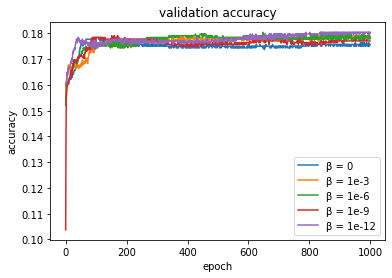

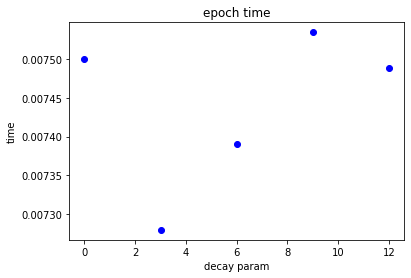

In [11]:
# summarize accuracy
plt.plot(acc_0)
plt.plot(acc_3)
plt.plot(acc_6)
plt.plot(acc_9)
plt.plot(acc_12)
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['β = 0', 'β = 1e-3', 'β = 1e-6', 'β = 1e-9', 'β = 1e-12'], loc='lower right')
plt.savefig("4aAcc.png")
plt.show()

# summarize epoch time
plt.plot(0, epoch_time_0, 'bo')
plt.plot(3, epoch_time_3,'bo')
plt.plot(6, epoch_time_6, 'bo')
plt.plot(9, epoch_time_9, 'bo')
plt.plot(12, epoch_time_12, 'bo')
plt.title('epoch time')
plt.ylabel('time')
plt.xlabel('decay param')
plt.savefig("4aTime.png")
plt.show()

